# Visualization of Magnetic Field Lines of Magnetic Dipole and Bottle
In this notebook, I employ an adaptive step size integration method (Runge–Kutta–Fehlberg) to visualize the magnetic field lines generated by two magnetic sources. The first source is a simple current loop lying in the x-y plane, which is referred to as the magnetic dipole. The second is a magnetic bottle along the y-axis, which consists of the combined field of four current loops (each in the x-z plane). In each of these two cases, visualizations are given using a set of initial conditions (seed points) in a 2 dimensional and 3 dimensional plot. Following this, self-convergence is demonstrated for the solution to an example seed point in the 3-dimensional magnetic bottle case using an RK4 integration method. Finally, Richardson extrapolation is used to determine an absolute error for the x, y, and z coordinates at a point in the same integration.

# 1. Visualization of Magnetic Field Lines

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import pi

In [2]:
# Definition of the magnetic field components from current loop in x-y plane as given in the problem statement
def Dipole_Bx(x, y, z, a=1, I=1):
    # In this and following instances, a is the loop radius and I the current through the loop
    term1 = 3*pi*(a**2)*I*x*z
    term2 = a**2 * (51*(x**2+y**2) + 16*z**2)
    term3 = 8 * (x**2 + y**2 + z**2)**2
    term4 = 8 * (a**2 + x**2 + y**2 + z**2)**(9/2)
    return term1*(43*a**4 + term2 + term3)/term4

def Dipole_By(x, y, z, a=1, I=1):
    term1 = 3*pi*a**2*I*y*z
    term2 = a**2 * (51*(x**2+y**2) + 16*z**2)
    term3 = 8 * (x**2 + y**2 + z**2)**2
    term4 = 8 * (a**2 + x**2 + y**2 + z**2)**(9/2)
    return term1*(43*a**4 + term2 + term3)/term4

def Dipole_Bz(x, y, z, a=1, I=1):
    term1 = 46*a**6 + a**4*(9*(x**2+y**2) + 78*z**2)
    term2 = 3*a**2*(36*z**2*(x**2+y**2) - 15*(x**2+y**2)**2 + 16*z**4)
    term3 = -8*(x**2+y**2-2*z**2)*(x**2+y**2+z**2)**2
    term4 = 8 * (a**2 + x**2 + y**2 + z**2)**(9/2)
    return pi*a**2*I*(term1 + term2 + term3)/term4

In [3]:
# Since the coordinates need to be integrated simultaneously, represent fields as a system of equations where field lines
# follow the integration along the magnetic field. Each coordinate of the line is determined by its field component
def Dipole_RHS(t, r, *P):
    x, y, z = r
    dx = Dipole_Bx(x, y, z, *P)
    dy = Dipole_By(x, y, z, *P)
    dz = Dipole_Bz(x, y, z, *P)
    return np.array([dx, dy, dz])

In [4]:
# Magnetic field components for the individual loops (x-z plane) of the magnetic bottle as given in the problem statement
def Bottle_Bx(x, y, z, a=1, I=1):
    term1 = 3*pi*(a**2)*I*x*y
    term2 = a**2 * (51*(x**2+z**2) + 16*y**2)
    term3 = 8 * (x**2 + y**2 + z**2)**2
    term4 = 8 * (a**2 + x**2 + y**2 + z**2)**(9/2)
    return term1*(43*a**4 + term2 + term3)/term4

def Bottle_By(x, y, z, a=1, I=1):
    term1 = 46*a**6 + a**4*(9*(x**2+z**2) + 78*y**2)
    term2 = 3*a**2*(36*y**2*(x**2+z**2) - 15*(x**2+z**2)**2 + 16*y**4)
    term3 = -8*(x**2+z**2-2*y**2)*(x**2+y**2+z**2)**2
    term4 = 8 * (a**2 + x**2 + y**2 + z**2)**(9/2)
    return pi*a**2*I*(term1 + term2 + term3)/term4

def Bottle_Bz(x, y, z, a=1, I=1):
    term1 = 3*pi*(a**2)*I*z*y
    term2 = a**2 * (51*(x**2+z**2) + 16*y**2)
    term3 = 8 * (x**2 + y**2 + z**2)**2
    term4 = 8 * (a**2 + x**2 + y**2 + z**2)**(9/2)
    return term1*(43*a**4 + term2 + term3)/term4

In [5]:
# Create total magnetic field from bottle at given point by superimposing field from four current loops
def Bottle_Superimpose(B, x, y, z, a, I, l):
    term1 = B(x, y-l, z, a, I)
    term2 = B(x, y-l/3, z, 10*a, I/5)
    term3 = B(x, y+l/3, z, 10*a, I/5)
    term4 = B(x, y+l, z, a, I)
    return term1 + term2 + term3 + term4

# As before, simultaneously integrate each coordinate using corresponding magnetic field component
def Bottle_RHS(t, r, *P):
    x, y, z = r
    dx = Bottle_Superimpose(Bottle_Bx, x, y, z, *P)
    dy = Bottle_Superimpose(Bottle_By, x, y, z, *P)
    dz = Bottle_Superimpose(Bottle_Bz, x, y, z, *P)
    return np.array([dx, dy, dz])

In [6]:
# Implementation of RKF45 method adapted from Dr. Elisabeth Krause
def odesolver45(g, t, r, h, *P):
    """Calculate the next step of an IVP of an ODE with a RHS
    described by f, with an order 4 approx. and an order 5 approx.
    Parameters:
        g: function. RHS of ODE.
        t: float. Current time.
        r: float. Current position.
        h: float. Step length.
        *P:    tuple, additional parameters for g function
    Returns:
        w: float. Order 5 approx.
        q: float. Order 4 approx.
    """
    k1 = g(t, r,*P)
    k2 = g(t+h/4.0, r+h*k1/4.0,*P)
    k3 = g(t+3.0*h/8.0, r+3.0*h*k1/32.0+9.0*h*k2/32.0,*P)
    k4 = g(t+12.0*h/13.0, r+1932.0*h*k1/2197.0-7200.0*h*k2/2197.0+7296.0*h*k3/2197.0,*P)
    k5 = g(t+h, r+439.0*h*k1/216.0-8.0*h*k2+3680.0*h*k3/513.0-845.0*h*k4/4104.0,*P)
    k6 = g(t+h/2.0, r-8.0*h*k1/27.0+2*h*k2-3544.0*h*k3/2565+1859.0*h*k4/4104.0-11.0*h*k5/40.0,*P)
    w = r + h*(25.0*k1/216.0+1408.0*k3/2565.0+2197.0*k4/4104.0-k5/5.0)
    q = r + h*(16.0*k1/135.0+6656.0*k3/12825.0+28561.0*k4/56430.0-9.0*k5/50.0+2.0*k6/55.0)
    return w, q

In [7]:
# Dynamic step size ODE solving method adapted from Dr. Elisabeth Krause
def rk_adaptive(ode, rhs, *P, eps=0.1, n=4, r0=np.zeros(3), t0=0.0, TOL=1e-4, theta=1e-2, tmax=1):
    """Perform an adaptive RK method.
    Parameters:
        ode:   function. ODE solver.
        rhs:   function. RHS of ODE.
        *P:    tuple.    Additional parameters for rhs function
        eps:   float,   optional. Tolerance for loop closing condition
        n:     integer, optional. Order of lowest order approximation
        r0:    array,   optional. Initial position.
        t0:    float,   optional. Initial time.
        TOL:   float,   optional. Tolerance of relative error.
        theta: float,   optional. "Protective" constant.
        tmax:  float,   optional. End of calculation interval.
    Returns:
        r:     list. Position.
        t:     list. Time.
        i:     int. Number of iterations
    """
    
    # Allocate lists to store position and time and set initial conditions
    r = []
    t = []
    r.append(r0)
    t.append(t0)
    
    # Set initial step size and declare iteration integer
    h = 0.01
    i = 0
    d_last = 0
    
    while (t[i] < tmax):
        # Get two different approximations
        w, q = ode(rhs, t[i], r[i], h,*P)
        # Estimate error
        e = abs(norm(w-q)/max(norm(w), theta))
        # If e larger thant TOL, decrease step length
        if (e > TOL):
            h = 0.8*(TOL*e)**(1./n)*h
            # Get two new approximations
            w, q = ode(rhs, t[i], r[i], h,*P)
            # Estimate new error
            e = abs(norm(w-q)/max(norm(w), theta))
            # If e still larger than TOL, halve step length until False
            while (e > TOL):
                h = h/2.0
                # New approximations
                w, q = ode(rhs, t[i], r[i], h,*P)
                # New error estimate
                e = abs(norm(w-q)/max(norm(w), theta))
    
        # Store highest order approximation as next r-value
        r.append(q)
        
        # Store current time + step size as next time
        t.append(t[i] + h)
        # Increment step number
        i += 1
        # Check if e is too small, if so, double step size
        if (e < 0.1*TOL):
            h = h*2.0
        
        if rhs == Dipole_RHS: # Extra condition for dipole case
            d = norm(q-r[0])/norm(r[0]) # distance to initial point
            if d < eps and d < d_last: # if within epsilon and moving towards point:
                return r, t, i # assume loop closed, exit integration
            d_last = d # otherwise set distance to compare next iteration to
            if d < 0.1: # if close to initial point, reduce step size to avoid overshooting
                h = 0.1
        elif rhs == Bottle_RHS: # Extra condition for bottle case
            if q[1] > 15: # if y > 15, exit integration
                return r, t, i
    
    # If conditions failed to be met, loop did not close/bottle did not reach y=15
    print("Integration error, magnetic field loop failed to close or bottle loop failed to reach y=15.")
    return r, t, i

## 1.1 Magnetic Dipole (Current Loop)

In [8]:
# Initial conditions for 3D visualization of dipole
N1 = 24 # Number of seed points
theta = np.linspace(0, 2*pi, N1)
a1 = np.stack((3 * np.cos(theta), 3 * np.sin(theta), 2 * np.ones(N1)), axis=1) # First set on circle r=3, z=2
a2 = np.stack((3 * np.cos(theta), 3 * np.sin(theta), 5 * np.ones(N1)), axis=1) # Second set on circle r=3, z=5

Initial condition set 1, seed point 0
Initial condition set 1, seed point 10
Initial condition set 1, seed point 20
Initial condition set 2, seed point 0
Initial condition set 2, seed point 10
Initial condition set 2, seed point 20


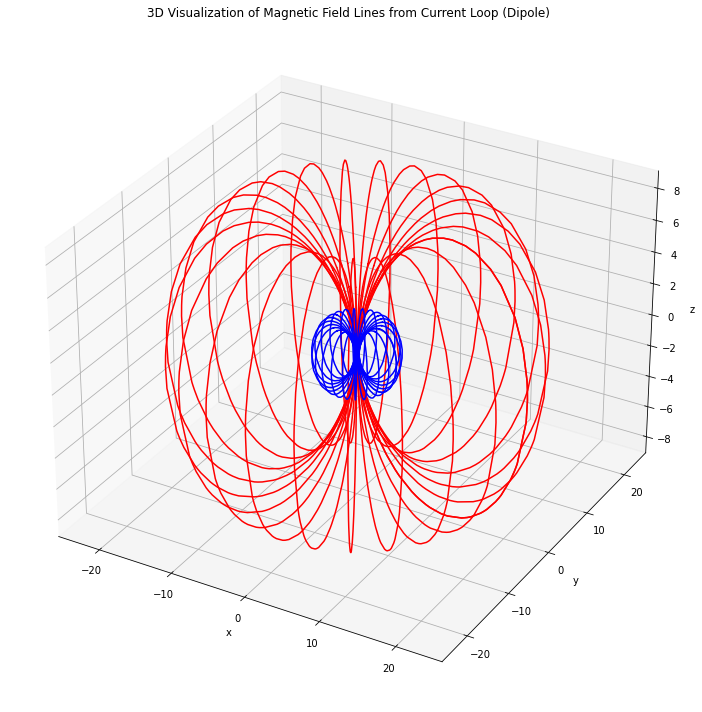

In [9]:
# Visualize field lines from above points in 3D plot
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
P = () # Use default parameters for dipole (a=0, I=0)

for i in range(0, N1): # Integrate over first set of initial conditions
    if i % 10 == 0: # Track progress of integration
        print("Initial condition set 1, seed point", i)
    # Carry out the integration
    r, times, iterations = rk_adaptive(odesolver45, Dipole_RHS, *P, eps=1e-2, r0=a2[i], TOL=1e-5, tmax=1e16)
    r = np.array(r) # Cast to array
    x = r[:,0] # Extract coordinates
    y = r[:,1]
    z = r[:,2]
    ax.plot(x, y, z, color='red')

for i in range(0, N1): # Integrate over second set of initial conditions
    if i % 10 == 0:
        print("Initial condition set 2, seed point", i)
    r, times, iterations = rk_adaptive(odesolver45, Dipole_RHS, *P, eps=1e-3, r0=a1[i], TOL=1e-5, tmax=1e16)
    r = np.array(r)
    x = r[:,0]
    y = r[:,1]
    z = r[:,2]
    ax.plot(x, y, z, color='blue')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('3D Visualization of Magnetic Field Lines from Current Loop (Dipole)')
plt.tight_layout()
plt.show()

In [10]:
# Initial conditions for 2D visualization of dipole
N2 = 24
L = 3
a3 = np.stack((np.linspace(-L/2, L/2, N2), np.zeros(N2), 2 * np.ones(N2)), axis=1) # First set along line at z=2
a4 = np.stack((np.linspace(-L/2, L/2, N2), np.zeros(N2), 5 * np.ones(N2)), axis=1) # Second set along line at z=5

Initial condition set 1, seed point 0
Initial condition set 1, seed point 10
Initial condition set 1, seed point 20
Initial condition set 2, seed point 0
Initial condition set 2, seed point 10
Initial condition set 2, seed point 20


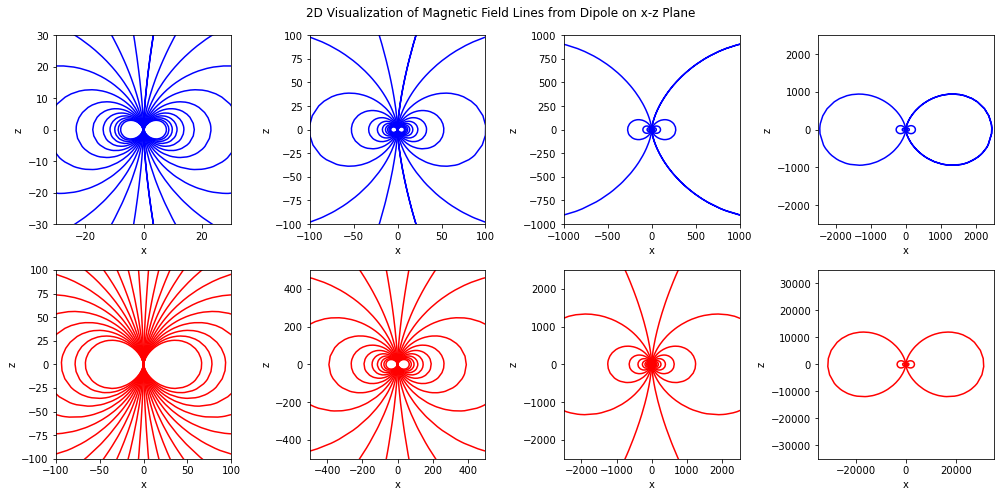

In [11]:
# Visualize field lines from above points in 2D plot
fig, ax = plt.subplots(2, 4, figsize=(14, 7))
P = ()

for i in range(0, N2): # Integrate over first (2D) set of initial conditions
    if i % 10 == 0:
        print("Initial condition set 1, seed point", i)
    r, times, iterations = rk_adaptive(odesolver45, Dipole_RHS, *P, eps=1e-2, r0=a3[i], TOL=1e-5, tmax=1e20)
    r = np.array(r)
    x = r[:,0]
    y = r[:,1]
    z = r[:,2]
    for i in range(4): # Multiple plots to see fields at different zoom levels
        ax[0,i].plot(x, z, color='blue')

for i in range(0, N2): # Integrate over second (2D) set of initial conditions
    if i % 10 == 0:
        print("Initial condition set 2, seed point", i)
    r, times, iterations = rk_adaptive(odesolver45, Dipole_RHS, *P, eps=1e-2, r0=a4[i], TOL=1e-5, tmax=1e20)
    r = np.array(r)
    x = r[:,0]
    y = r[:,1]
    z = r[:,2]
    for i in range(4):
        ax[1,i].plot(x, z, color='red')

zoom1 = [30, 100, 1000, 2500] # Arbitrary arrays to see magnetic fields at different scales
zoom2 = [100, 500, 2500, 35000]
for j in range(4): # Set zoom of plots
    ax[0,j].set_xlim(-1*zoom1[j], zoom1[j])
    ax[0,j].set_ylim(-1*zoom1[j], zoom1[j])
    ax[1,j].set_xlim(-1*zoom2[j], zoom2[j])
    ax[1,j].set_ylim(-1*zoom2[j], zoom2[j])
    ax[0,j].set_xlabel('x')
    ax[0,j].set_ylabel('z')
    ax[1,j].set_xlabel('x')
    ax[1,j].set_ylabel('z')

fig.suptitle("2D Visualization of Magnetic Field Lines from Dipole on x-z Plane")
plt.tight_layout()
plt.show()

## 1.2 Magnetic Bottle

In [12]:
# Initial conditions for 3D visualization of magnetic bottle 
N3 = 19
theta = np.linspace(0, 2*pi, N3)
a5 = np.stack((0.5 * np.cos(theta), -15 * np.ones(N3), 0.5 * np.sin(theta)), axis=1) # First set on circle r=0.5, y=-15
a6 = np.stack((1.0 * np.cos(theta), -15 * np.ones(N3), 1.0 * np.sin(theta)), axis=1) # Second set on circle r=1.0, y=-15
a7 = np.stack((1.5 * np.cos(theta), -15 * np.ones(N3), 1.5 * np.sin(theta)), axis=1) # Third set on circle r=1.5, y=-15
a8 = np.stack((2.0 * np.cos(theta), -15 * np.ones(N3), 2.0 * np.sin(theta)), axis=1) # Fourth set on circle r=2.0, y=-15

Initial condition set 1, seed point 0
Initial condition set 1, seed point 5
Initial condition set 1, seed point 10
Initial condition set 1, seed point 15
Initial condition set 2, seed point 0
Initial condition set 2, seed point 5
Initial condition set 2, seed point 10
Initial condition set 2, seed point 15
Initial condition set 3, seed point 0
Initial condition set 3, seed point 5
Initial condition set 3, seed point 10
Initial condition set 3, seed point 15
Initial condition set 4, seed point 0
Initial condition set 4, seed point 5
Initial condition set 4, seed point 10
Initial condition set 4, seed point 15


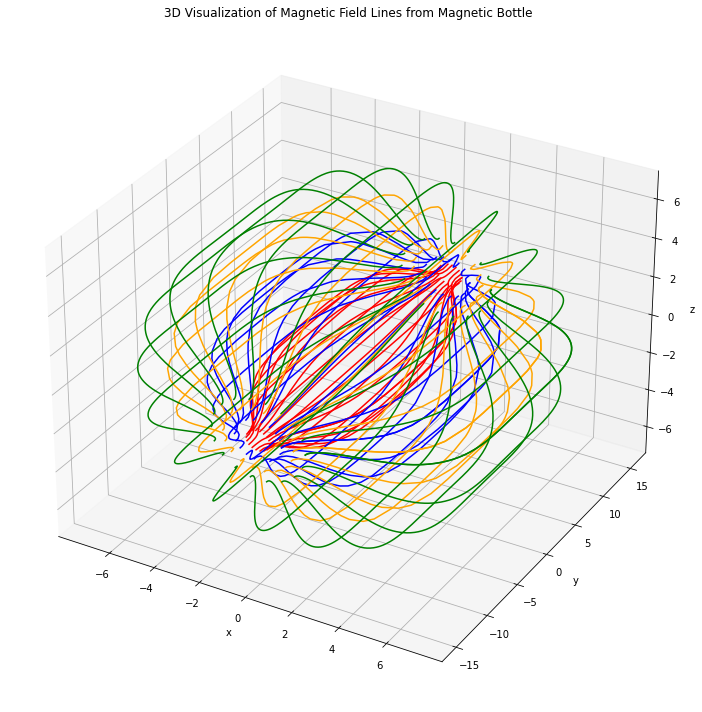

In [13]:
# Visualize field lines from above points in 3D plot
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
P = (3, 10, 15) # Specific parameters (a, I, L) from problem statement

for i in range(0, N3): # Integrate over first (3D Magnetic Bottle) set of initial conditions
    r, times, iterations = rk_adaptive(odesolver45, Bottle_RHS, *P, r0=a5[i], TOL=1e-5, tmax=1e6)
    if i % 5 == 0:
        print("Initial condition set 1, seed point", i)
    r = np.array(r)
    x = r[:,0]
    y = r[:,1]
    z = r[:,2]
    ax.plot(x, y, z, color='red')

for i in range(0, N3): # Integrate over second (3D Magnetic Bottle) set of initial conditions
    r, times, iterations = rk_adaptive(odesolver45, Bottle_RHS, *P, r0=a6[i], TOL=1e-5, tmax=1e6)
    if i % 5 == 0:
        print("Initial condition set 2, seed point", i)
    r = np.array(r)
    x = r[:,0]
    y = r[:,1]
    z = r[:,2]
    ax.plot(x, y, z, color='blue')

for i in range(0, N3): # Integrate over third (3D Magnetic Bottle) set of initial conditions
    r, times, iterations = rk_adaptive(odesolver45, Bottle_RHS, *P, r0=a7[i], TOL=1e-5, tmax=1e4)
    if i % 5 == 0:
        print("Initial condition set 3, seed point", i)
    r = np.array(r)
    x = r[:,0]
    y = r[:,1]
    z = r[:,2]
    ax.plot(x, y, z, color='orange')

for i in range(0, N3): # Integrate over fourth (3D Magnetic Bottle) set of initial conditions
    r, times, iterations = rk_adaptive(odesolver45, Bottle_RHS, *P, r0=a8[i], TOL=1e-10, tmax=1e4)
    if i % 5 == 0:
        print("Initial condition set 4, seed point", i)
    r = np.array(r)
    x = r[:,0]
    y = r[:,1]
    z = r[:,2]
    ax.plot(x, y, z, color='green')
    
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('3D Visualization of Magnetic Field Lines from Magnetic Bottle')
plt.tight_layout()
plt.show()

In [14]:
# Initial conditions for 2D visualization of magnetic bottle
N4 = 15
L = 5
a9 = np.stack((np.linspace(-L/2, L/2, N4), -15 * np.ones(N4), np.zeros(N4)), axis=1) # Set along line at y=-15, z=0

Seed point 0
Seed point 5
Seed point 10


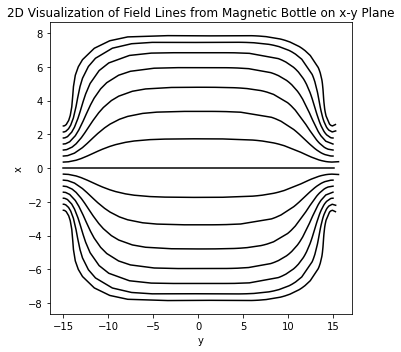

In [15]:
# Visualize field lines from above points in 2D plot
fig, ax = plt.subplots(figsize=(5, 5))
P = (3, 10, 15)

for i in range(0, N4):
    if i % 5 == 0:
        print("Seed point", i)
    r, times, iterations = rk_adaptive(odesolver45, Bottle_RHS, *P, eps=1e-2, r0=a9[i], TOL=1e-5, tmax=1e20)
    r = np.array(r)
    x = r[:,0]
    y = r[:,1]
    z = r[:,2]
    ax.plot(y, x, color='black')

plt.xlabel('y')
plt.ylabel('x')
plt.title("2D Visualization of Field Lines from Magnetic Bottle on x-y Plane")
plt.tight_layout()
plt.show()

# 2. Self Convergence
Because the previous method uses an adaptive step size, there is no trivial way to analyze convergence, so here I switch to a standard RK4 implementation. Using a sample seed point, the integration will be caried out on a variety of step sizes. By comparing larger step sizes to the finest ones, a plot can be constructed to demonstrate that the solution converges to a certain valued of the x, y, and z coordinates as the step size gets smaller.

In [16]:
# ODE solving helper function adapted from Dr. Elisabeth Krause
def odeSolve(method, rhs, r0, h, *P, t0=0, tmax=8):
    """ODE driver with constant step-size, allowing systems of ODE's.
    Parameters:
        method: function. Method for ODE solution
        rhs:    function. RHS of ODE.
        r0:     array.    Initial conditions
        *P:     tuple.    Additional parameters for rhs function
        h:      float.    Step size
        t0:     float, optional. Initial time.
        tmax:   float, optional. End of calculation interval.
    Returns:
        r:     array. Position.
        t:     array. Time.
        i:     int. Number of iterations
    """

    # make array of times and find length of array, make positions array
    t = np.arange(t0,tmax+h,h)
    ntimes,  = t.shape
    r = np.zeros( (ntimes, 3) )

    # set first element of solution to initial conditions
    r[0] = r0

    # carry out integration
    for i in range(0,ntimes-1):
        r[i+1] = method(t[i], r[i], h, rhs, *P)

    return r, t, i

In [17]:
# Standard implementation of RK4 method adapted from Dr. Elisabeth Krause
def RK4_step(t, r, h, g, *P):
    """
    Implements a single step of a fourth-order, explicit Runge-Kutta scheme
    """
    thalf = t + 0.5*h
    k1 = h * g(t, r, *P)
    k2 = h * g(thalf, r + 0.5*k1, *P)
    k3 = h * g(thalf, r + 0.5*k2, *P)
    k4 = h * g(t + h, r + k3, *P)
    return r + (k1 + 2*k2 + 2*k3 + k4)/6

In [18]:
a10 = a7[2] # Arbitrarily chosen seed point from 3D magnetic bottle case
tf = 1 # Integrate to t=1

N = np.array([300.,400.,500.,600.,700.]) # Number of points to discretize interval for each trial step size
N5 = len(N) # Number of trial step size values
hs = (tf)/N # Construct trial step sizes (h)
N2 = 800.
h2 = (tf)/N2 # h2 value
N3 = 1600.
h3 = (tf)/N3 # h3 value

In [19]:
P = (3, 10, 15) # Parameters from 3D magnetic bottle
hx = np.zeros(N5) # Arrays for solution at t=1 for each coordinate
hy = np.zeros(N5)
hz = np.zeros(N5)

for i in range(0, N5): # Integrate with each step size
    print(f"Integration {i}, h = {hs[i]}")
    r, times, iterations = odeSolve(RK4_step, Bottle_RHS, a10, hs[i], *P, tmax=tf)
    r = np.array(r)
    hx[i] = r[int(N[i]), 0] # Save coordinate values for each integration
    hy[i] = r[int(N[i]), 1]
    hz[i] = r[int(N[i]), 2]

print(f"Integration {N5}, h = {h2}") # Integrate with step size h2
r2, times, iterations = odeSolve(RK4_step, Bottle_RHS, a10, h2, *P, tmax=tf)
h2x, h2y, h2z = tuple(r2[int(N2)])

print(f"Integration {N5 + 1}, h = {h3}") # Integrate with step size h3
r3, times, iterations = odeSolve(RK4_step, Bottle_RHS, a10, h3, *P, tmax=tf)
h3x, h3y, h3z = tuple(r3[int(N3)])

Integration 0, h = 0.0033333333333333335
Integration 1, h = 0.0025
Integration 2, h = 0.002
Integration 3, h = 0.0016666666666666668
Integration 4, h = 0.0014285714285714286
Integration 5, h = 0.00125
Integration 6, h = 0.000625


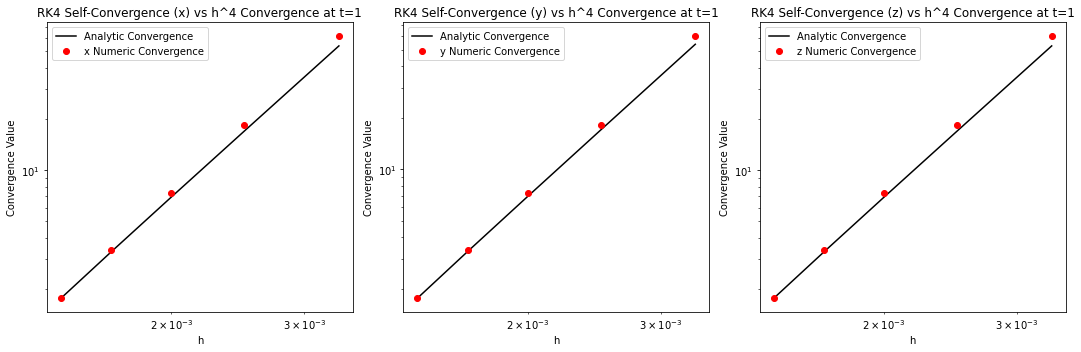

In [20]:
# Construct a self-convergence plot as demonstrated in Problem Set 4
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
n = 4 # Expected order of convergence
# The formula used is equation (7) from Problem Set 4, the value of which I refer to as the "Convergence Value"
RHS = ((hs/h3)**n - 1) / (2**n - 1) # Analytic expression for "Convergence Value"

LHSx = (hx - h3x) / (h2x - h3x) # Numerical value for "Convergence Value" for each coordinate
LHSy = (hy - h3y) / (h2y - h3y)
LHSz = (hz - h3z) / (h2z - h3z)

coords = ('x', 'y', 'z')
# Plot numerical and analytic "Convergence Value" against step size to analyze self-convergence
for i, j in enumerate((LHSx, LHSy, LHSz)): 
    ax[i].loglog(hs, RHS, color='black', label = "Analytic Convergence")
    ax[i].loglog(hs, j, 'o', color='red', label = f"{coords[i]} Numeric Convergence")
    ax[i].legend()
    ax[i].set_title(f"RK4 Self-Convergence ({coords[i]}) vs h^4 Convergence at t=1")
    ax[i].set_xlabel("h")
    ax[i].set_ylabel("Convergence Value")

plt.tight_layout()
plt.show()

The analytic and numerical values agree, which from the derivation of equation (7) in problem set 4 demonstrates
successful self-convergence. Taking the integration with step size h3 as a reference solution, the ratio of the
error at a given h to that at the second finest step size, h2, decreases at the expected order. Thus the RK4
integration successfully converges to the solution at $O(h^4)$.

# 3. Richardson Extrapolation
Following the above derivation, the solution converges at $O(h^4)$. To estimate the magnitude of the truncation error, which for RK4 is $O(h^5)$ since the solution converges at fifth order, one can construct a higher order approximation for the solution using Richardson Extrapolation. For simplicity, reuse conditions from the last section, using the same seed point and integrating to $t=1$.

In [21]:
# Use the finest step size from the previous section as the less accurate estimate
h = h3
r3, times, iterations = odeSolve(RK4_step, Bottle_RHS, a10, h, *P, tmax=tf)
# Construct a more accurate estimate with half the step size (twice the integration steps) as previous
r4, times, iterations = odeSolve(RK4_step, Bottle_RHS, a10, h/2, *P, tmax=tf)
I0x, I0y, I0z = tuple(r3[int(N3)]) # Extract solution for each coordinate
I1x, I1y, I1z = tuple(r4[int(N3*2)])

x = 16/15 * I1x - 1/15 * I0x # Richardson extrapolation formula, derivation in report
y = 16/15 * I1y - 1/15 * I0y
z = 16/15 * I1z - 1/15 * I0z

print(f"Previous x: {h3x}, Improved x estimate: {x}, Error: {abs(x-h3x)}") # Compare old and new estimates
print(f"Previous y: {h3y}, Improved y estimate: {y}, Error: {abs(y-h3y)}")
print(f"Previous z: {h3z}, Improved z estimate: {z}, Error: {abs(z-h3z)}")

Previous x: 3.7671629437995704, Improved x estimate: 3.7671629437800704, Error: 1.949995720451625e-11
Previous y: -10.905907298924221, Improved y estimate: -10.905907298843692, Error: 8.052936095737095e-11
Previous z: 3.161025036726944, Improved z estimate: 3.1610250367105737, Error: 1.6370460542702858e-11


Since the improved estimates from the Richardson extrapolation converge at order $O(h^5)$ and the old ones at $O(h^4)$, subtracting the previous values from the extrapolated ones yields an estimate of the $O(h^5)$ truncation error term of the RK4 integration.